### Importación de datos



In [92]:
from typing import Generator
import pandas as pd

datos_tienda = [
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv",
]

class Tienda:

  def __init__(self, alias: str, data: str) -> None:
    self.nombre = alias
    self.df_reader = pd.read_csv(data)
    self.df_reader["Fecha de Compra"] = pd.to_datetime(self.df_reader["Fecha de Compra"], format="%d/%m/%Y")

  def get_values(self, col: str) -> Generator:
    for value in self.df_reader[col].to_list():
      yield value

  def ventas(self) -> float:
    return round(self.df_reader["Precio"].sum(), 2)

  def categorías(self) -> dict:
    # when using gruopby the values in the col become the labels for
    # the row position in the new grouped table, with agg you can create custom
    # rows with aliases and defined values similar to the aggragate method
    # in django
    name_alias = f"total de ventas por categoría"
    # to_dict by default return values like {col: {index: value}}
    return self.df_reader.groupby("Categoría del Producto").agg(**{name_alias: ("Producto", "count")}).sort_values(by=name_alias, ascending=False).to_dict()

  def valoración_promedio(self, col: str) -> float:
    return round(self.df_reader[col].mean(), 2)

  def más_y_menos_vendido(self) -> dict:
    name_alias = f"producto más vendido en {self.nombre}"
    # when grouping the group columns becocome the id of the dataframe, each unique category
    # or combinations of categories in the group becomes the id of the new table, reset id transform
    # back to columns the categories and adds normal index
    grouped = self.df_reader.groupby(["Producto", "Categoría del Producto"]).agg(**{name_alias: ("Precio", "count")}).reset_index()
    más = grouped[name_alias].idxmax()
    menos = grouped[name_alias].idxmin()
    # iloc stands for index location loc is for locacte with names
    columns = ["Producto", "Categoría", "Cantidad",]
    return {"más vendido": {key: grouped.iloc[más, val] for key, val in zip(columns, (range(len(columns))))},
            "menos vendido": {key: grouped.iloc[menos, val] for key, val in zip(columns, (range(len(columns))))},
            }
  def ventas_por_año(self) -> dict:
    new_df = pd.DataFrame({"Año de compra": self.df_reader["Fecha de Compra"].dt.year.tolist(),
                          "Precio de la venta": self.df_reader["Precio"].tolist()})
    return new_df.groupby("Año de compra").agg(**{"Ventas por año": ("Precio de la venta", "count")}).to_dict()

  def valor_promedio_categoría(self) -> dict:
    return self.df_reader.groupby("Categoría del Producto").agg(**{"Valor promedio producto": ("Precio", "mean")}).round(2).to_dict()

names = [f"tienda {i}" for i in range(1,5)]
resultados = []
for nombre, datos in zip(names, datos_tienda):
  resultados.append(Tienda(nombre, datos))



#1. Análisis de facturación



In [70]:
# cantidades vendidas por cada tienda
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.ventas())



tienda 1 1150880400.0
tienda 2 1116343500.0
tienda 3 1098019600.0
tienda 4 1038375700.0


# 2. Ventas por categoría

In [71]:
current_data_item = {}
for tienda_ob in resultados:
  target_dict =  tienda_ob.categorías()["total de ventas por categoría"]
  current_data_item[tienda_ob.nombre] = {key: target_dict[key] for key in sorted(target_dict.keys(), reverse=True)}
  print(tienda_ob.nombre, current_data_item[tienda_ob.nombre])

tienda 1 {'Muebles': 465, 'Libros': 173, 'Juguetes': 324, 'Instrumentos musicales': 182, 'Electrónicos': 448, 'Electrodomésticos': 312, 'Deportes y diversión': 284, 'Artículos para el hogar': 171}
tienda 2 {'Muebles': 442, 'Libros': 197, 'Juguetes': 313, 'Instrumentos musicales': 224, 'Electrónicos': 422, 'Electrodomésticos': 305, 'Deportes y diversión': 275, 'Artículos para el hogar': 181}
tienda 3 {'Muebles': 499, 'Libros': 185, 'Juguetes': 315, 'Instrumentos musicales': 177, 'Electrónicos': 451, 'Electrodomésticos': 278, 'Deportes y diversión': 277, 'Artículos para el hogar': 177}
tienda 4 {'Muebles': 480, 'Libros': 187, 'Juguetes': 338, 'Instrumentos musicales': 170, 'Electrónicos': 451, 'Electrodomésticos': 254, 'Deportes y diversión': 277, 'Artículos para el hogar': 201}


# 3. Calificación promedio de la tienda


In [72]:
opinion_usuario = {}
for tienda_ob in resultados:
  opinion_usuario[tienda_ob.nombre] = tienda_ob.valoración_promedio("Calificación")
  print(tienda_ob.nombre, opinion_usuario[tienda_ob.nombre])

tienda 1 3.98
tienda 2 4.04
tienda 3 4.05
tienda 4 4.0


# 4. Productos más y menos vendidos

In [93]:
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.más_y_menos_vendido())

tienda 1 {'más vendido': {'Producto': 'Armario', 'Categoría': 'Muebles', 'Cantidad': np.int64(60)}, 'menos vendido': {'Producto': 'Auriculares con micrófono', 'Categoría': 'Electrónicos', 'Cantidad': np.int64(33)}}
tienda 2 {'más vendido': {'Producto': 'Iniciando en programación', 'Categoría': 'Libros', 'Cantidad': np.int64(65)}, 'menos vendido': {'Producto': 'Juego de mesa', 'Categoría': 'Juguetes', 'Cantidad': np.int64(32)}}
tienda 3 {'más vendido': {'Producto': 'Kit de bancas', 'Categoría': 'Muebles', 'Cantidad': np.int64(57)}, 'menos vendido': {'Producto': 'Bloques de construcción', 'Categoría': 'Juguetes', 'Cantidad': np.int64(35)}}
tienda 4 {'más vendido': {'Producto': 'Cama box', 'Categoría': 'Muebles', 'Cantidad': np.int64(62)}, 'menos vendido': {'Producto': 'Guitarra eléctrica', 'Categoría': 'Instrumentos musicales', 'Cantidad': np.int64(33)}}


# 5. Envío promedio por tienda

In [74]:
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.valoración_promedio("Costo de envío"))

tienda 1 26018.61
tienda 2 25216.24
tienda 3 24805.68
tienda 4 23459.46


# 6. Ventas por año

In [75]:
data_sale_year = {}
for tienda_año in resultados:
  data_sale_year[tienda_año.nombre] = tienda_año.ventas_por_año()["Ventas por año"]
  print(tienda_año.nombre, data_sale_year[tienda_año.nombre])

tienda 1 {2020: 715, 2021: 739, 2022: 713, 2023: 192}
tienda 2 {2020: 700, 2021: 759, 2022: 708, 2023: 192}
tienda 3 {2020: 701, 2021: 740, 2022: 740, 2023: 178}
tienda 4 {2020: 745, 2021: 744, 2022: 712, 2023: 157}


# 7. Promedio de valor item por categoría


In [76]:
data_tienda_mean = {}
for tienda_mean in resultados:
  data_tienda_mean[tienda_mean.nombre] = tienda_mean.valor_promedio_categoría()["Valor promedio producto"]
  print(tienda_mean.nombre, data_tienda_mean[tienda_mean.nombre])

tienda 1 {'Artículos para el hogar': 74259.65, 'Deportes y diversión': 138345.07, 'Electrodomésticos': 1165657.69, 'Electrónicos': 958690.85, 'Instrumentos musicales': 501642.86, 'Juguetes': 55542.28, 'Libros': 50779.77, 'Muebles': 403513.33}
tienda 2 {'Artículos para el hogar': 81474.59, 'Deportes y diversión': 126343.64, 'Electrodomésticos': 1142845.25, 'Electrónicos': 973533.41, 'Instrumentos musicales': 468706.7, 'Juguetes': 50943.77, 'Libros': 51224.37, 'Muebles': 399154.52}
tienda 3 {'Artículos para el hogar': 85084.75, 'Deportes y diversión': 128494.95, 'Electrodomésticos': 1184308.99, 'Electrónicos': 910811.09, 'Instrumentos musicales': 437180.23, 'Juguetes': 61590.79, 'Libros': 51344.32, 'Muebles': 402950.1}
tienda 4 {'Artículos para el hogar': 74997.51, 'Deportes y diversión': 120397.47, 'Electrodomésticos': 1115197.64, 'Electrónicos': 907929.27, 'Instrumentos musicales': 441778.82, 'Juguetes': 59947.34, 'Libros': 49846.52, 'Muebles': 401101.88}


# 8. Graficos

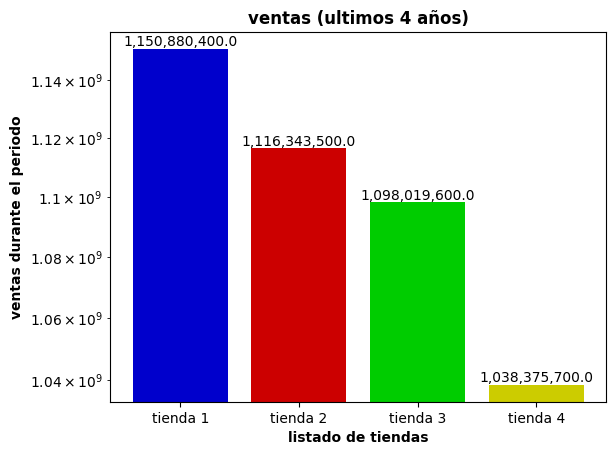

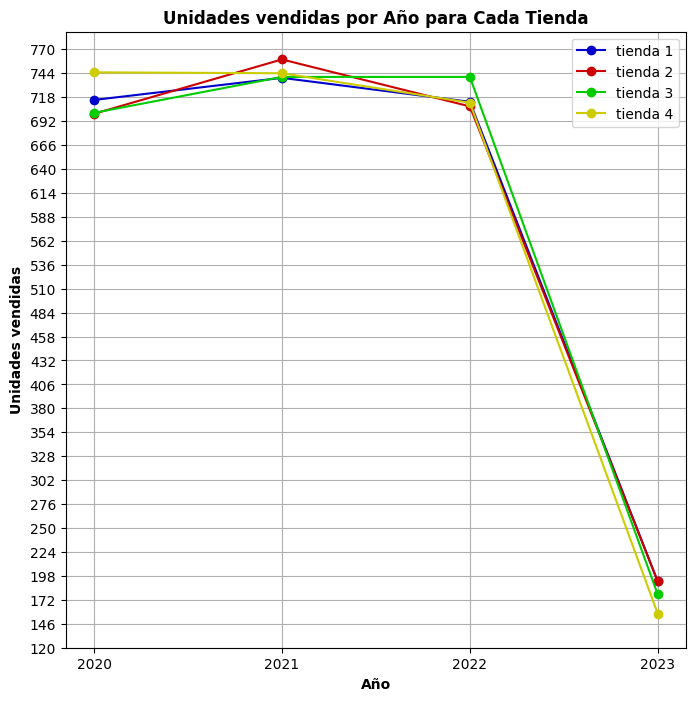

In [82]:
import matplotlib.pyplot as plt
import numpy as np
# ventas
ventas = [float(item.ventas()) for item in resultados]
nombres = [item.nombre for item in resultados]
colores = "#0000cc", "#cc0000", "#00cc00", "#cccc00"
plt.bar(nombres, ventas, color=colores)
plt.yscale("log")
for count, item in enumerate(ventas):
  plt.text(count, item, f"{item:,}", ha='center', va='bottom')
plt.title("ventas (ultimos 4 años)", fontweight="bold")
plt.ylabel("ventas durante el periodo", fontweight="bold")
plt.xlabel("listado de tiendas", fontweight="bold")
plt.show()

# ventas unitarias por año para cada tienda

plt.figure(figsize=(8, 8))
for hue, tienda, ventas in zip(colores, data_sale_year.keys(), data_sale_year.values()):
    plt.plot(list(ventas.keys()), list(ventas.values()), marker='o', label=tienda, color=hue)
plt.xlabel("Año", fontweight="bold")
plt.ylabel("Unidades vendidas", fontweight="bold")
plt.title("Unidades vendidas por Año para Cada Tienda", fontweight="bold")
plt.xticks(list(data_sale_year['tienda 1'].keys()))
plt.yticks(np.arange(120, 771, 26))
plt.legend()
plt.grid(True)
plt.show()

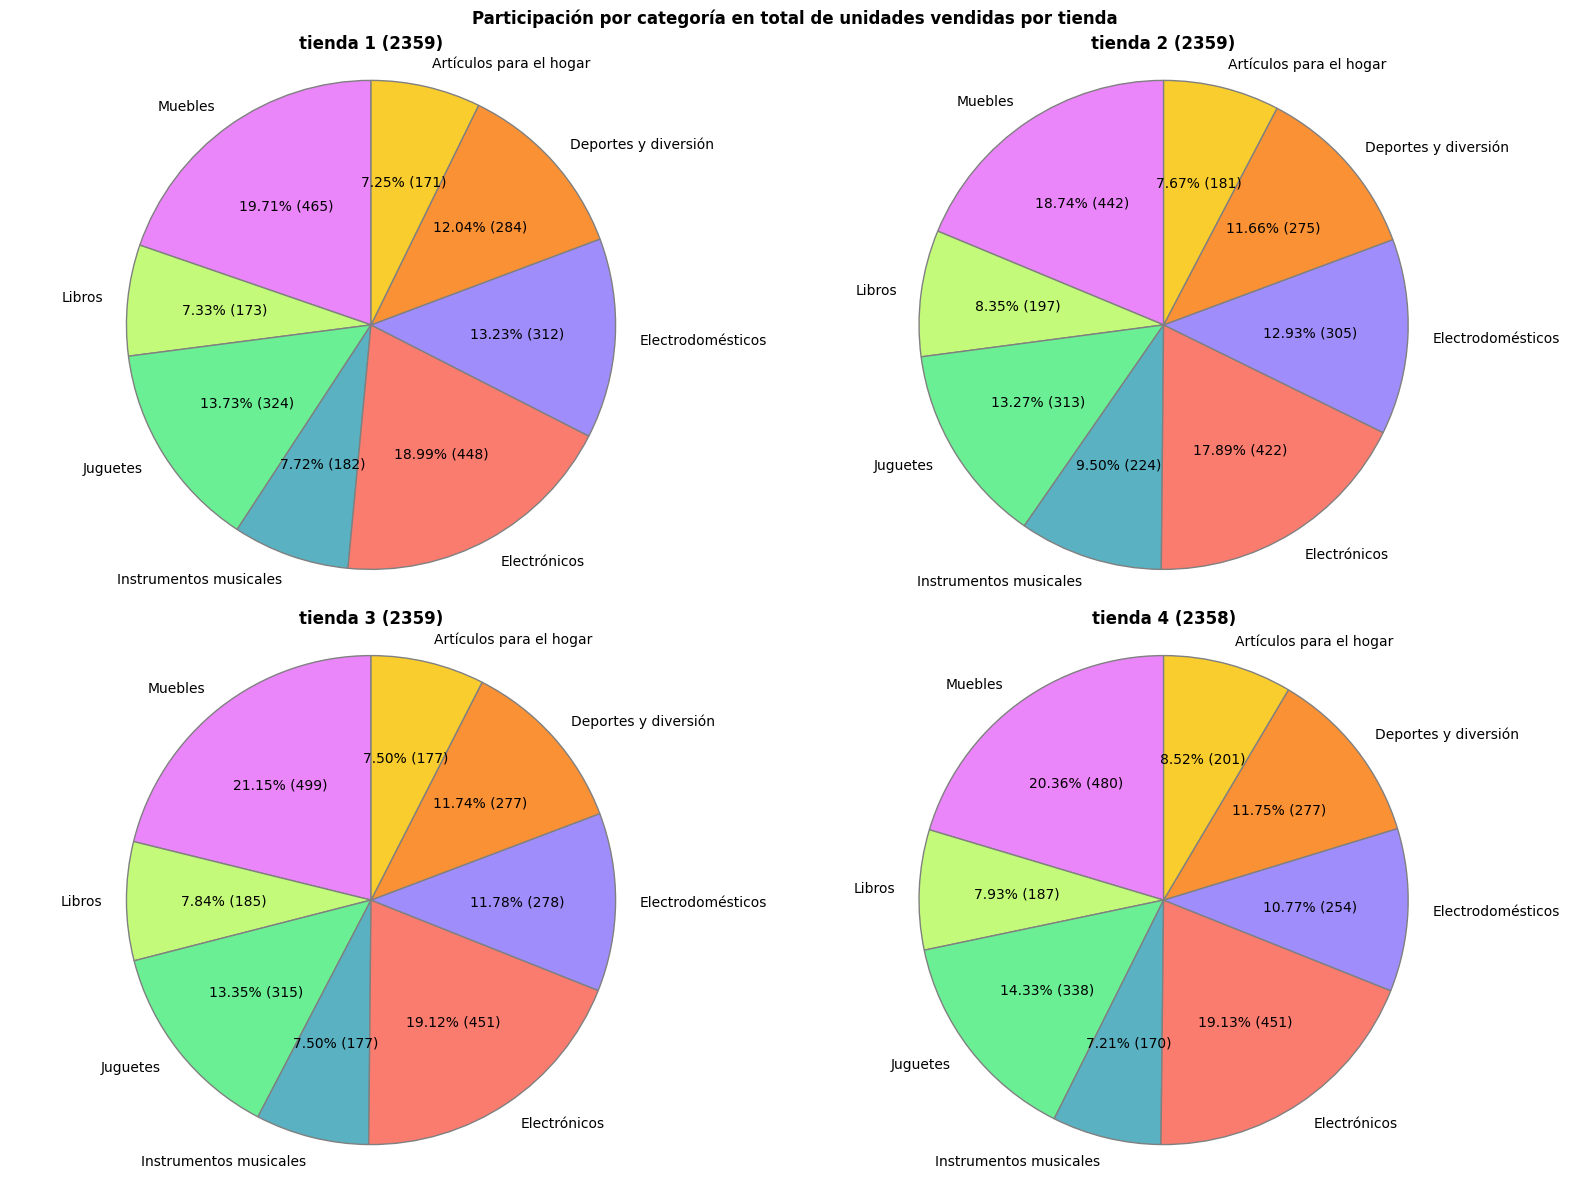

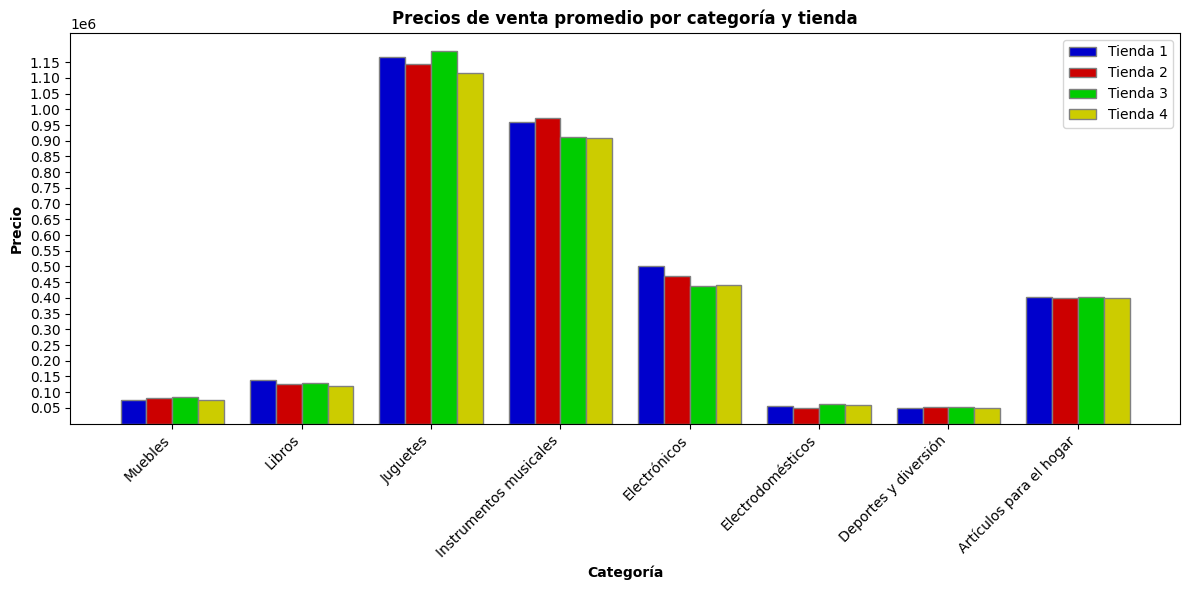

In [54]:
import matplotlib.pyplot as plt

# Datos de ventas por categoría de producto para cada tienda

def auto_pct_format(valores):
    def custom_pct(pct):
        total = sum(valores)
        val = int(round(pct*total/100.0))
        return f"{pct:.2f}% ({val:d})"
    return custom_pct

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

colors = ["#EA85FA", "#C4FA79", "#6AEF94", "#59B1C2", "#FA7C6F", "#9E8DFA", "#FA9135", "#FACD2E"]

for i, (tienda, datos_tienda) in enumerate(current_data_item.items()):
    categorias = list(datos_tienda.keys())
    valores = list(datos_tienda.values())

    row = i // 2
    col = i % 2

    axs[row, col].pie(valores, labels=categorias, autopct=auto_pct_format(valores), startangle=90, colors=colors,
                   wedgeprops={"edgecolor": "gray"})
    axs[row, col].set_title(f"{tienda} ({sum(valores)})", fontweight="bold")
    axs[row, col].axis("equal")
fig.suptitle("Participación por categoría en total de unidades vendidas por tienda", fontweight="bold")
plt.tight_layout()




categorías = list(list(data_tienda_mean.values())[0].keys())
ancho_barra = 0.2
plt.figure(figsize=(12, 6))
bar_start_positioning_range = np.arange(len(categorías))
for position, bar_color, tienda_data_mean, dict_value in zip(range(len(colores)), colores, data_tienda_mean.keys(), data_tienda_mean.values()):
  mean_price = list(dict_value.values())
  bar_positioning = [i + ancho_barra*position for i in bar_start_positioning_range]
  plt.bar(bar_positioning, mean_price, color=bar_color, width=ancho_barra, edgecolor="grey", label=tienda_data_mean.title())

plt.xlabel("Categoría", fontweight="bold")
plt.ylabel("Precio", fontweight="bold")
plt.title("Precios de venta promedio por categoría y tienda", fontweight="bold")
plt.xticks([r + ancho_barra*1.5 for r in range(len(categorias))], categorias, rotation=45, ha="right")
plt.yticks(np.arange(50_000, 1_200_000, 50_000))

plt.legend()

plt.tight_layout()

plt.show()

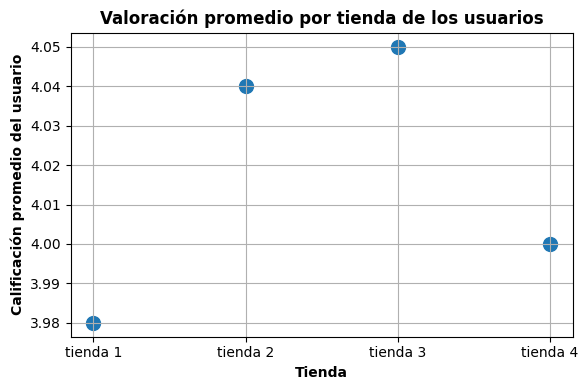

In [83]:
# item más y menos vendido por tienda y categoría

# calificación por tienda

plt.figure(figsize=(6, 4))
plt.scatter(list(opinion_usuario.keys()), list(opinion_usuario.values()), s=100)

plt.xlabel("Tienda", fontweight="bold")
plt.ylabel("Calificación promedio del usuario", fontweight="bold")
plt.title("Valoración promedio por tienda de los usuarios", fontweight="bold")
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# distribución geografica de ventas